# Amazon Bedrock boto3 Check

> *This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio*

---

In this demo notebook, we demonstrate how to use the [`boto3` Python SDK](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) to work with [Amazon Bedrock](https://aws.amazon.com/bedrock/) Foundation Models.

---

## Create the boto3 client

Interaction with the Bedrock API is done via the AWS SDK for Python: [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html).

Depending on your environment, you might need to customize the setup when creating your Bedrock service client. To help with this, we've provided a `get_bedrock_client()` utility method that supports passing in different options. You can find the implementation in [../utils/bedrock.py](../utils/bedrock.py)

#### Use different clients
The boto3 provides different clients for Amazon Bedrock to perform different actions. The actions for [`InvokeModel`](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InvokeModel.html) and [`InvokeModelWithResponseStream`](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_runtime_InvokeModelWithResponseStream.html) are supported by Amazon Bedrock Runtime where as other operations, such as [ListFoundationModels](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_ListFoundationModels.html), are handled via [Amazon Bedrock client](https://docs.aws.amazon.com/bedrock/latest/APIReference/API_Operations_Amazon_Bedrock.html).

The `get_bedrock_client()` method accepts `runtime` (default=True) parameter to return either `bedrock` or `bedrock-runtime` client.

#### Use the default credential chain

If you are running this notebook from [Amazon Sagemaker Studio](https://aws.amazon.com/sagemaker/studio/) and your Sagemaker Studio [execution role](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) has permissions to access Bedrock you can just run the cells below as-is. This is also the case if you are running these notebooks from a computer whose default AWS credentials have access to Bedrock.

#### Use a different AWS Region

If you're running this notebook from your own computer or a SageMaker notebook in a different AWS Region from where Bedrock is set up, you can un-comment the `os.environ['AWS_DEFAULT_REGION']` line below and specify the region to use.

#### Use a specific profile

In case you're running this notebook from your own computer where you have setup the AWS CLI with multiple profiles, and the profile which has access to Bedrock is not the default one, you can un-comment the `os.environ['AWS_PROFILE']` line below and specify the profile to use.

#### Use a different role

In case you or your company has setup a specific, separate [IAM Role](https://docs.aws.amazon.com/IAM/latest/UserGuide/id_roles.html) to access Bedrock, you can specify it by un-commenting the `os.environ['BEDROCK_ASSUME_ROLE']` line below. Ensure that your current user or role have permissions to [assume](https://docs.aws.amazon.com/STS/latest/APIReference/API_AssumeRole.html) such role.

#### A note about `langchain`

The Bedrock classes provided by `langchain` create a Bedrock boto3 client by default. To customize your Bedrock configuration, we recommend to explicitly create the Bedrock client using the method below, and pass it to the [`langchain.Bedrock`](https://python.langchain.com/docs/integrations/llms/bedrock) class instantiation method using `client=boto3_bedrock`

In [2]:
import json
import os
import sys

import boto3
import botocore

module_path = ".."
sys.path.append(os.path.abspath(module_path))
from utils import bedrock, print_ww


# ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----

# os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
# os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
# os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."


boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
    runtime=False
)


Create new client
  Using region: us-east-1
boto3 Bedrock client successfully created!
bedrock(https://bedrock.us-east-1.amazonaws.com)


#### Validate the connection

We can check the client works by trying out the `list_foundation_models()` method, which will tell us all the models available for us to use 

In [3]:
boto3_bedrock.list_foundation_models()


{'ResponseMetadata': {'RequestId': '045af638-937d-4d90-bb6d-47b6e0bc6fa4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Mon, 20 Nov 2023 15:52:58 GMT',
   'content-type': 'application/json',
   'content-length': '8988',
   'connection': 'keep-alive',
   'x-amzn-requestid': '045af638-937d-4d90-bb6d-47b6e0bc6fa4'},
  'RetryAttempts': 0},
 'modelSummaries': [{'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-tg1-large',
   'modelId': 'amazon.titan-tg1-large',
   'modelName': 'Titan Text Large',
   'providerName': 'Amazon',
   'inputModalities': ['TEXT'],
   'outputModalities': ['TEXT'],
   'responseStreamingSupported': True,
   'customizationsSupported': ['FINE_TUNING'],
   'inferenceTypesSupported': ['ON_DEMAND']},
  {'modelArn': 'arn:aws:bedrock:us-east-1::foundation-model/amazon.titan-embed-g1-text-02',
   'modelId': 'amazon.titan-embed-g1-text-02',
   'modelName': 'Titan Text Embeddings v2',
   'providerName': 'Amazon',
   'inputModalities': ['TEXT'],
   'ou

---

## `InvokeModel` body and output

The `invoke_model()` method of the Amazon Bedrock runtime client (`InvokeModel` API) will be the primary method we use for most of our Text Generation and Processing tasks - whichever model we're using.

Although the method is shared, the format of input and output varies depending on the foundation model used - as described below:

### Amazon Titan Large

#### Input
```json
{   
    "inputText": "<prompt>",
    "textGenerationConfig" : { 
        "maxTokenCount": 512,
        "stopSequences": [],
        "temperature": 0.1,  
        "topP": 0.9
    }
}
```

#### Output

```json
{
    "inputTextTokenCount": 613,
    "results": [{
        "tokenCount": 219,
        "outputText": "<output>"
    }]
}
```

### AI21 Jurassic (Grande and Jumbo) 

#### Input

```json
{
    "prompt": "<prompt>",
    "maxTokens": 200,
    "temperature": 0.5,
    "topP": 0.5,
    "stopSequences": [],
    "countPenalty": {"scale": 0},
    "presencePenalty": {"scale": 0},
    "frequencyPenalty": {"scale": 0}
}
```

#### Output

```json
{
    "id": 1234,
    "prompt": {
        "text": "<prompt>",
        "tokens": [
            {
                "generatedToken": {
                    "token": "\u2581who\u2581is",
                    "logprob": -12.980147361755371,
                    "raw_logprob": -12.980147361755371
                },
                "topTokens": null,
                "textRange": {"start": 0, "end": 6}
            },
            //...
        ]
    },
    "completions": [
        {
            "data": {
                "text": "<output>",
                "tokens": [
                    {
                        "generatedToken": {
                            "token": "<|newline|>",
                            "logprob": 0.0,
                            "raw_logprob": -0.01293118204921484
                        },
                        "topTokens": null,
                        "textRange": {"start": 0, "end": 1}
                    },
                    //...
                ]
            },
            "finishReason": {"reason": "endoftext"}
        }
    ]
}
```

### Anthropic Claude

#### Input

```json
{
    "prompt": "\n\nHuman:<prompt>\n\nAnswer:",
    "max_tokens_to_sample": 300,
    "temperature": 0.5,
    "top_k": 250,
    "top_p": 1,
    "stop_sequences": ["\n\nHuman:"]
}
```

#### Output

```json
{
    "completion": "<output>",
    "stop_reason": "stop_sequence"
}
```

### Stability AI Stable Diffusion XL

#### Input

```json
{
    "text_prompts": [
        {"text": "this is where you place your input text"}
    ],
    "cfg_scale": 10,
    "seed": 0,
    "steps": 50
}
```

#### Output

```json
{ 
    "result": "success", 
    "artifacts": [
        {
            "seed": 123, 
            "base64": "<image in base64>",
            "finishReason": "SUCCESS"
        },
        //...
    ]
}
```

---

## Common inference parameter definitions

### Randomness and Diversity

Foundation models support the following parameters to control randomness and diversity in the 
response.

**Temperature** – Large language models use probability to construct the words in a sequence. For any 
given next word, there is a probability distribution of options for the next word in the sequence. When 
you set the temperature closer to zero, the model tends to select the higher-probability words. When 
you set the temperature further away from zero, the model may select a lower-probability word.

In technical terms, the temperature modulates the probability density function for the next tokens, 
implementing the temperature sampling technique. This parameter can deepen or flatten the density 
function curve. A lower value results in a steeper curve with more deterministic responses, and a higher 
value results in a flatter curve with more random responses.

**Top K** – Temperature defines the probability distribution of potential words, and Top K defines the cut 
off where the model no longer selects the words. For example, if K=50, the model selects from 50 of the 
most probable words that could be next in a given sequence. This reduces the probability that an unusual 
word gets selected next in a sequence.
In technical terms, Top K is the number of the highest-probability vocabulary tokens to keep for Top-
K-filtering - This limits the distribution of probable tokens, so the model chooses one of the highest-
probability tokens.

**Top P** – Top P defines a cut off based on the sum of probabilities of the potential choices. If you set Top 
P below 1.0, the model considers the most probable options and ignores less probable ones. Top P is 
similar to Top K, but instead of capping the number of choices, it caps choices based on the sum of their 
probabilities.
For the example prompt "I hear the hoof beats of ," you may want the model to provide "horses," 
"zebras" or "unicorns" as the next word. If you set the temperature to its maximum, without capping 
Top K or Top P, you increase the probability of getting unusual results such as "unicorns." If you set the 
temperature to 0, you increase the probability of "horses." If you set a high temperature and set Top K or 
Top P to the maximum, you increase the probability of "horses" or "zebras," and decrease the probability 
of "unicorns."

### Length

The following parameters control the length of the generated response.

**Response length** – Configures the minimum and maximum number of tokens to use in the generated 
response.

**Length penalty** – Length penalty optimizes the model to be more concise in its output by penalizing 
longer responses. Length penalty differs from response length as the response length is a hard cut off for 
the minimum or maximum response length.

In technical terms, the length penalty penalizes the model exponentially for lengthy responses. 0.0 
means no penalty. Set a value less than 0.0 for the model to generate longer sequences, or set a value 
greater than 0.0 for the model to produce shorter sequences.

### Repetitions

The following parameters help control repetition in the generated response.

**Repetition penalty (presence penalty)** – Prevents repetitions of the same words (tokens) in responses. 
1.0 means no penalty. Greater than 1.0 decreases repetition.

---

## Try out the models

With some theory out of the way, let's see the models in action! Run the cells below to see basic, synchronous example invocations for each model:

In [4]:
bedrock_runtime = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None)
)


Create new client
  Using region: us-east-1
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)


### Anthropic Claude

In [5]:
# If you'd like to try your own prompt, edit this parameter!
prompt_data = """Human: Write me a blog about making strong business decisions as a leader.

Assistant:
"""


In [6]:
body = json.dumps({"prompt": prompt_data, "max_tokens_to_sample": 500})
modelId = "anthropic.claude-instant-v1"  # change this to use a different version from the model provider
accept = "application/json"
contentType = "application/json"

try:

    response = bedrock_runtime.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())

    print(response_body.get("completion"))

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


 Here is a draft blog post on making strong business decisions as a leader:

How to Make Strong Business Decisions as a Leader

As a business leader, making important decisions is part of the job. However, not all decisions are created equal, and some can have major impacts on the company's success if handled improperly. Here are some tips for making strong business decisions that will help move your organization in the right direction:

Consider all relevant factors. When facing an important decision, take the time to thoughtfully consider all relevant business factors, not just the most obvious ones. This includes analyzing financial metrics, market conditions, competitive landscape, customer needs, staffing requirements, and potential risks or obstacles. Gathering input from different departments can help give you a well-rounded perspective.

Rely on data, not gut feelings. While experience and intuition are valuable, major decisions should be based on hard data and facts whenever p

### AI21 Jurassic Grande

In [7]:
body = json.dumps({"prompt": prompt_data, "maxTokens": 200})
modelId = "ai21.j2-mid-v1"  # change this to use a different version from the model provider
accept = "application/json"
contentType = "application/json"

try:

    response = bedrock_runtime.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())

    print(response_body.get("completions")[0].get("data").get("text"))

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


As a leader, you are constantly faced with decisions that can have a lasting impact on your business. Making strong, well-informed decisions is a critical skill for a leader.

One of the most important factors to consider when making business decisions is the goal you are trying to achieve. Having a clear understanding of what you want to achieve will help you make decision that align with this goal.

Another factor to consider when making business decisions is the potential consequences of your decisions. It is important to consider the potential positive and negative impacts of your decision, and to weight them against the goal you are trying to achieve.

Finally, it is important to consider the values and culture of your company when making business decisions. It is important to make decisions that are in line with your company's values and culture, and that will inspire and motivate your employees.

By considering these factors, you can make strong, well-informed decisions that wil

### Stability Stable Diffusion XL

In [8]:
prompt_data = "Prague castle with st. vitus cathedral in Czech Republic on the Vltava river with a charles bridge"
body = json.dumps({
    "text_prompts": [{"text": prompt_data}],
    "cfg_scale": 10,
    "seed": 20,
    "steps": 50
})
modelId = "stability.stable-diffusion-xl"
accept = "application/json"
contentType = "application/json"

try:

    response = bedrock_runtime.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())

    print(response_body["result"])
    print(f'{response_body.get("artifacts")[0].get("base64")[0:80]}...')

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


success
iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAAACGGVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


**Note:** The output is a [base64 encoded](https://docs.python.org/3/library/base64.html) string of the image data. You can use any image processing library (such as [Pillow](https://pillow.readthedocs.io/en/stable/)) to decode the image as in the example below:

```python
import base64
import io
from PIL import Image

base_64_img_str = response_body.get("artifacts")[0].get("base64")
image = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
```

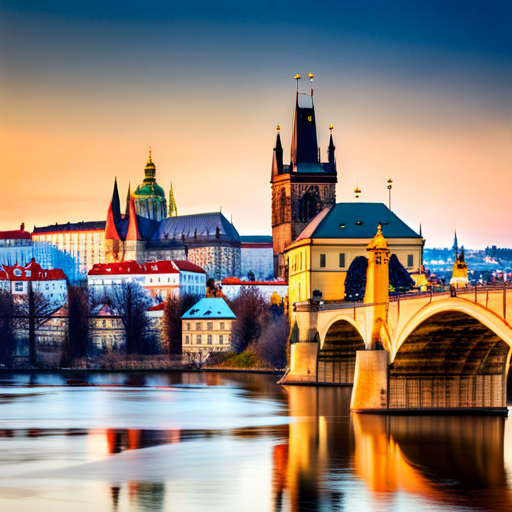

In [9]:
import base64
import io
from PIL import Image

base_64_img_str = response_body.get("artifacts")[0].get("base64")
image = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
image

## Generate streaming output

For large language models, it can take noticeable time to generate long output sequences. Rather than waiting for the entire response to be available, latency-sensitive applications may like to **stream** the response to users.

Run the code below to see how you can achieve this with Bedrock's `invoke_model_with_response_stream()` method - returning the response body in separate chunks.

### Anthropic Claude

In [10]:
# If you'd like to try your own prompt, edit this parameter!
prompt_data = """Human: Write me a blog about making strong business decisions as a leader.

Assistant:
"""


In [11]:
from IPython.display import clear_output, display, display_markdown, Markdown

body = json.dumps({"prompt": prompt_data, "max_tokens_to_sample": 500})
modelId = "anthropic.claude-instant-v1"  # (Change this to try different model versions)
accept = "application/json"
contentType = "application/json"

try:

    response = bedrock_runtime.invoke_model_with_response_stream(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    stream = response.get('body')
    output = []

    if stream:
        for event in stream:
            chunk = event.get('chunk')
            if chunk:
                chunk_obj = json.loads(chunk.get('bytes').decode())
                text = chunk_obj['completion']
                clear_output(wait=True)
                output.append(text)
                display_markdown(Markdown(''.join(output)))

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


 Here is a draft blog post on making strong business decisions as a leader:

Making Strong Business Decisions as a Leader

As the head of a company or the manager of a team, the buck stops with you when it comes to making important business decisions. Whether choosing where to invest resources, developing new strategies, or setting company-wide priorities, the choices you make will directly impact your business's performance and success. 

While making decisions is an inevitable part of any leadership role, not all choices are created equal. Here are some tips for making strong, impactful business decisions that will move your company in the right direction:

Consider all angles. Resist the urge to rush into a decision before gathering all relevant information. Take time to understand an issue from different perspectives before settling on a solution. Consult with other leaders and subject matter experts to gain insights you may have otherwise overlooked.

Look at past patterns. Review historical data on similar past decisions to see what worked well and what didn't. Understand trends to potentially forecast outcomes. Learn from prior successes and failures to help guide your decision making process.

Weigh short and long-term impacts. Evaluate how a decision may affect your business in both the near and more distant future. Opt for choices that provide ongoing value rather than just solving an immediate problem. Consider unintended consequences that could emerge over time. 

Trust your intuition - sometimes. While data and facts are important, don't be afraid to go with your gut on certain "feeling" decisions if extensive research still leaves you unsure. Just be prepared to own the outcome either way.

Get input but make the call yourself. Gather perspectives from others to enhance your view but ultimately the responsibility is yours. Don't abdicate the final decision or you risk losing authority as a leader. Own your choices.

Review and refine as needed. Periodically re-visit major decisions as situations evolve to determine if adjustments are warranted. Be ready to course-correct rather than stubbornly sticking to a plan if it's clearly not working out as hoped.

Strong leaders make strong decisions through comprehensive consideration of options, understanding cause-and-effect relationships, and trusting but also challenging their own assumptions. Mastering the art of good judgment will take your business further.

## Generate embeddings

Use text embeddings to convert text into meaningful vector representations. You input a body of text 
and the output is a (1 x n) vector. You can use embedding vectors for a wide variety of applications. 
Bedrock currently offers Titan Embeddings for text embedding that supports text similarity (finding the 
semantic similarity between bodies of text) and text retrieval (such as search).

At the time of writing you can use `amazon.titan-embed-text-v1` as embedding model via the API. The input text size is 8192 tokens and the output vector length is 1536.

To use a text embeddings model, use the InvokeModel API operation or the Python SDK.
Use InvokeModel to retrieve the vector representation of the input text from the specified model.



#### Input

```json
{
    "inputText": "<text>"
}
```

#### Output

```json
{
    "embedding": []
}
```


Let's see how to generate embeddings of some text:

In [12]:
prompt_data = "Amazon Bedrock supports foundation models from industry-leading providers such as \
AI21 Labs, Anthropic, Stability AI, and Amazon. Choose the model that is best suited to achieving \
your unique goals."


In [13]:
body = json.dumps({"inputText": prompt_data})
modelId = "amazon.titan-embed-text-v1"  # (Change this to try different embedding models)
accept = "application/json"
contentType = "application/json"

try:

    response = bedrock_runtime.invoke_model(
        body=body, modelId=modelId, accept=accept, contentType=contentType
    )
    response_body = json.loads(response.get("body").read())

    embedding = response_body.get("embedding")
    print(f"The embedding vector has {len(embedding)} values\n{embedding[0:3]+['...']+embedding[-3:]}")

except botocore.exceptions.ClientError as error:

    if error.response['Error']['Code'] == 'AccessDeniedException':
           print(f"\x1b[41m{error.response['Error']['Message']}\
                \nTo troubeshoot this issue please refer to the following resources.\
                 \nhttps://docs.aws.amazon.com/IAM/latest/UserGuide/troubleshoot_access-denied.html\
                 \nhttps://docs.aws.amazon.com/bedrock/latest/userguide/security-iam.html\x1b[0m\n")

    else:
        raise error


The embedding vector has 1536 values
[0.16601562, 0.23632812, 0.703125, '...', 0.26953125, -0.609375, -0.55078125]


## Next steps

In this notebook we showed some basic examples of invoking Amazon Bedrock models using the AWS Python SDK. You're now ready to explore the other labs to dive deeper on different use-cases and patterns.